In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from passivbot import *
from vwap import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = [21, 13]
pd.set_option('precision', 10)

In [4]:
user = 'your_user_name_here'
commons, vwap, streamer = prepare_bot('binance', user)
vwap.stop_updater()
commons.stop_call_limiter()


25 / 25 calculating ema for ZEC/BTC ...   
2020-07-22T16:34:57  margin updating balance 
2020-07-22T16:34:58  margin updating my trades ADA/BTC 
2020-07-22T16:34:58  margin updating my trades ATOM/BTC 
2020-07-22T16:34:58  margin updating my trades BAT/BTC 
2020-07-22T16:34:58  margin updating my trades BCH/BTC 
2020-07-22T16:34:58  margin updating my trades BNB/BTC 
2020-07-22T16:34:58  margin updating my trades DASH/BTC 
2020-07-22T16:34:59  margin updating my trades EOS/BTC 
2020-07-22T16:34:59  margin updating my trades ETC/BTC 
2020-07-22T16:34:59  margin updating my trades ETH/BTC 
2020-07-22T16:34:59  margin updating my trades IOST/BTC 
2020-07-22T16:34:59  margin updating my trades IOTA/BTC 
2020-07-22T16:34:59  margin updating my trades LINK/BTC 
2020-07-22T16:34:59  margin updating my trades LTC/BTC 
2020-07-22T16:35:00  margin updating my trades MATIC/BTC 
2020-07-22T16:35:00  margin updating my trades NEO/BTC 
2020-07-22T16:35:00  margin updating my trades ONT/BTC 
2020-07

In [5]:
equities = {}
borrowed = {}
oh = {}
for c in vwap.balance:
    if c not in vwap.all_coins_set:
        continue
    if type(vwap.balance[c]) == int:
        continue
    equities[c] = vwap.balance[c]['equity'] / vwap.balance[c]['account_equity']
    borrowed[c] = vwap.balance[c]['borrowed'] / vwap.balance[c]['account_debt']
    oh[c] = vwap.balance[c]['onhand'] / vwap.balance[c]['account_equity']
print('\n\n(coin equity) divided by (account equity in terms of coin)\n')
for e in sorted(equities.items(), key=lambda x: x[1]):
    print(e)




(coin equity) divided by (account equity in terms of coin)

('ETH', -0.8619966623150083)
('ONT', -0.30349184094322124)
('IOTA', -0.22521674665469324)
('XRP', -0.10179633198224075)
('EOS', -0.062206213012369116)
('ZEC', -0.057602560553801495)
('QTUM', -0.054745633097550005)
('IOST', -0.04493223064789456)
('XMR', -0.031933157479536615)
('DASH', -0.020436826951676635)
('NEO', -0.01118679863047354)
('VET', -0.004601747512769001)
('BAT', -0.004596039922194909)
('XTZ', -0.003657730801971131)
('BCH', -0.002165251010876018)
('LINK', -0.0004295731696772774)
('MATIC', 4.8796572941366806e-05)
('ETC', 9.15238364076892e-05)
('ATOM', 0.0003786174814201695)
('XLM', 0.000565080660502396)
('RVN', 0.0013035115811273492)
('ADA', 0.002280920831674111)
('TRX', 0.006054269002065629)
('BNB', 0.07019932222636903)
('LTC', 0.6502011343604297)
('BTC', 2.0564564898079034)
2020-07-22T16:35:06  margin dumping balance 
2020-07-22T16:35:07  warning, 1595428505.375787 seconds since last websocket tick streamer proba

In [6]:
vwap.balance['BTC']

{'free': 2.29e-06,
 'used': 0.47266494,
 'borrowed': 0.0,
 'interest': 0.0,
 'equity': 0.47266723,
 'onhand': 0.47266723,
 'debt': 0.0,
 'liquidate': False,
 'borrowable': 0.0,
 'account_onhand': 0.6887761919445645,
 'account_debt': 0.45893071145781106,
 'account_equity': 0.22984548048675346}

In [7]:
# uncomment and run this to set emas to current price
'''
tickers = vwap.cc.fetch_tickers()
for sym in vwap.symbols:
    vwap.cm.last_price[sym] = tickers[sym]['last']
    vwap.cm.min_ema[sym] = tickers[sym]['last']   
    vwap.cm.max_ema[sym] = tickers[sym]['last']   
'''

"\ntickers = vwap.cc.fetch_tickers()\nfor sym in vwap.symbols:\n    vwap.cm.last_price[sym] = tickers[sym]['last']\n    vwap.cm.min_ema[sym] = tickers[sym]['last']   \n    vwap.cm.max_ema[sym] = tickers[sym]['last']   \n"

In [8]:
print('n days trade history in memory\n')
rm_ = [((vwap.my_trades[s][-1]['timestamp'] - vwap.my_trades[s][0]['timestamp']) / 1000 / 60 / 60 / 24, s) for s in vwap.symbols]
for e in sorted(rm_):
    print(f"{e[1]:13} {e[0]:.2f}")

n days trade history in memory

XTZ/BTC       59.78
MATIC/BTC     61.02
IOST/BTC      61.12
NEO/BTC       61.30
VET/BTC       61.35
IOTA/BTC      61.44
TRX/BTC       61.50
ATOM/BTC      61.50
BAT/BTC       61.56
BCH/BTC       61.56
LINK/BTC      61.58
XLM/BTC       61.67
ETC/BTC       61.74
RVN/BTC       61.74
DASH/BTC      61.76
ADA/BTC       61.76
QTUM/BTC      61.77
ETH/BTC       61.77
XRP/BTC       61.77
XMR/BTC       61.78
ZEC/BTC       61.78
BNB/BTC       61.79
EOS/BTC       61.79
ONT/BTC       61.79
LTC/BTC       61.79


In [27]:
# set symbol for analysis
s = 'IOTA/BTC'
c, q = s.split('/')

In [28]:
vwap.update_balance()
#vwap.init_my_trades(s)
vwap.update_my_trades(s)
vwap.init_loan_history(c, 'borrow')
vwap.init_loan_history(c, 'repay')

2020-07-22T16:37:39  margin updating balance 
2020-07-22T16:37:40  margin updating my trades IOTA/BTC 


In [29]:
vwap.update_open_orders(s)
print(f'\ncurrent open orders for {s}\n')
for my_orders in [vwap.my_bids[s], vwap.my_asks[s]]:
    for o in my_orders:
        print({k: o[k] for k in ['symbol', 'side', 'amount', 'price']})


2020-07-22T16:37:45  margin updating open orders IOTA/BTC 

current open orders for IOTA/BTC

{'symbol': 'IOTA/BTC', 'side': 'buy', 'amount': 4.0, 'price': 2.867e-05}


In [30]:
events = sorted(vwap.my_trades[s] + vwap.borrow_history[c] + vwap.repay_history[c], key=lambda x: x['timestamp'])
do_print = False
n = 50
print(f'most recent {n} events')
for e in events[-n:]:
    line = f"{ts_to_date(e['timestamp'] / 1000)[:19]}  {e['side']:7} {e['amount']:.8f}"
    if 'price' in e:
        do_print = True
        line += f" {e['price']}"
    if do_print:
        print(line)

most recent 50 events
2020-07-21T22:14:22  buy     4.00000000 2.791e-05
2020-07-21T22:15:32  buy     4.00000000 2.79e-05
2020-07-21T22:18:22  buy     4.00000000 2.79e-05
2020-07-21T22:21:11  buy     4.00000000 2.789e-05
2020-07-21T22:23:07  buy     4.00000000 2.789e-05
2020-07-21T22:25:41  buy     4.00000000 2.788e-05
2020-07-21T22:28:24  buy     4.00000000 2.788e-05
2020-07-21T22:33:45  buy     2.00000000 2.788e-05
2020-07-21T22:33:48  buy     2.00000000 2.788e-05
2020-07-21T22:42:42  buy     4.00000000 2.788e-05
2020-07-21T22:47:37  buy     4.00000000 2.789e-05
2020-07-21T22:49:33  buy     4.00000000 2.789e-05
2020-07-21T22:50:46  buy     4.00000000 2.789e-05
2020-07-21T22:52:10  buy     4.00000000 2.788e-05
2020-07-21T22:54:29  buy     4.00000000 2.788e-05
2020-07-21T23:08:17  buy     4.00000000 2.789e-05
2020-07-21T23:52:52  sell    290.00000000 2.816e-05
2020-07-21T23:52:57  repay   26.00000000
2020-07-21T23:52:57  sell    29.00000000 2.817e-05
2020-07-22T00:52:04  repay   6.90000

In [31]:
for s_ in vwap.symbols:
#for s_ in [s]:
    vwap.set_ideal_orders(s_)
vwap.allocate_credit()
for c_ in [c, q]:
    for key in ['free', 'onhand', 'debt', 'borrowable']:
        print(f"{c_} {key:10} {vwap.balance[c_][key]}")
    print()
print('borrow', vwap.ideal_borrow[c])
print('repay ', vwap.ideal_repay[c])
print()
print('ideal orders')
print('long_buy', vwap.ideal_long_buy[s])
print('shrt_sel', vwap.ideal_shrt_sel[s])
print('long_sel', vwap.ideal_long_sel[s])
print('shrt_buy', vwap.ideal_shrt_buy[s])
print()
print('eligible orders')
for order in vwap.eligible_entries + vwap.eligible_exits:
    if order['symbol'] == s:
        print(order)
print()
print('sum sel amounts', vwap.ideal_shrt_sel[s]['amount'] + vwap.ideal_long_sel[s]['amount'])
print('sum onhand', vwap.balance[c]['onhand'] + vwap.ideal_borrow[c])
print()
print('sum buys cost', (vwap.ideal_shrt_buy[s]['amount'] * vwap.ideal_shrt_buy[s]['price'] +
                        vwap.ideal_long_buy[s]['amount'] * vwap.ideal_long_buy[s]['price']))
now_millis = vwap.cc.milliseconds()
max_cost_per_symbol_per_hour = vwap.settings['account_equity_pct_per_hour'] / len(vwap.symbols)
small_trade_cost = max(vwap.min_trade_costs[s],
                       vwap.balance[q]['account_equity'] * vwap.settings['account_equity_pct_per_trade'])
entry_delay_millis = (60 * 60 * 1000) / (max_cost_per_symbol_per_hour / small_trade_cost)
print('\ndelay between entries minutes', round(entry_delay_millis / 1000 / 60, 2))
print('minutes since prev long entry',
      round((now_millis - vwap.my_trades_analyses[s]['last_long_entry_ts']) / 1000 / 60, 2))
print('minutes since prev shrt entry',
      round((now_millis - vwap.my_trades_analyses[s]['last_shrt_entry_ts']) / 1000 / 60, 2))



IOTA free       0.0
IOTA onhand     0.0
IOTA debt       1773.268
IOTA borrowable 0.0

BTC free       5.81e-06
BTC onhand     0.4736918
BTC debt       0.0
BTC borrowable 0.0

borrow 0.0
repay  0.0

ideal orders
long_buy {'side': 'buy', 'amount': 4.0, 'price': 2.867e-05}
shrt_sel {'side': 'sell', 'amount': 31.0, 'price': 2.925e-05}
long_sel {'side': 'sell', 'amount': 8730.0, 'price': 2.924e-05}
shrt_buy {'side': 'buy', 'amount': 10484.0, 'price': 2.383e-05}

eligible orders
{'symbol': 'IOTA/BTC', 'side': 'buy', 'amount': 4.0, 'price': 2.867e-05}

sum sel amounts 8761.0
sum onhand 0.0

sum buys cost 0.24994840000000002

delay between entries minutes 7.5
minutes since prev long entry 518.38
minutes since prev shrt entry 508.67


In [32]:
# true size of positions
vwap.my_trades_analyses[s]

{'true_long_amount': 8730.0,
 'true_long_cost': 0.20226398999999973,
 'true_long_vwap': 2.3168841924398595e-05,
 'true_shrt_amount': 10484.0,
 'true_shrt_cost': 0.2505635499999997,
 'true_shrt_vwap': 2.3899613697062162e-05,
 'long_start_ts': 1590128054129,
 'shrt_start_ts': 1590097296431,
 'last_long_entry_ts': 1595397605955,
 'last_shrt_entry_ts': 1595398188463,
 'entry_exit_amount_threshold': 99.0,
 'long_sel_price': 2.323e-05,
 'shrt_buy_price': 2.383e-05}

In [33]:
# dataframe of all trades
n_days = vwap.settings['max_memory_span_days']
mts = vwap.fetch_my_trades(s)
mtdf = pd.DataFrame(mts).set_index('timestamp').drop(['id', 'order_id', 'type'], axis=1)
mtdf = mtdf[mtdf.index > (vwap.cc.milliseconds() - 1000 * 60 * 60 * 24 * n_days)]

99.0


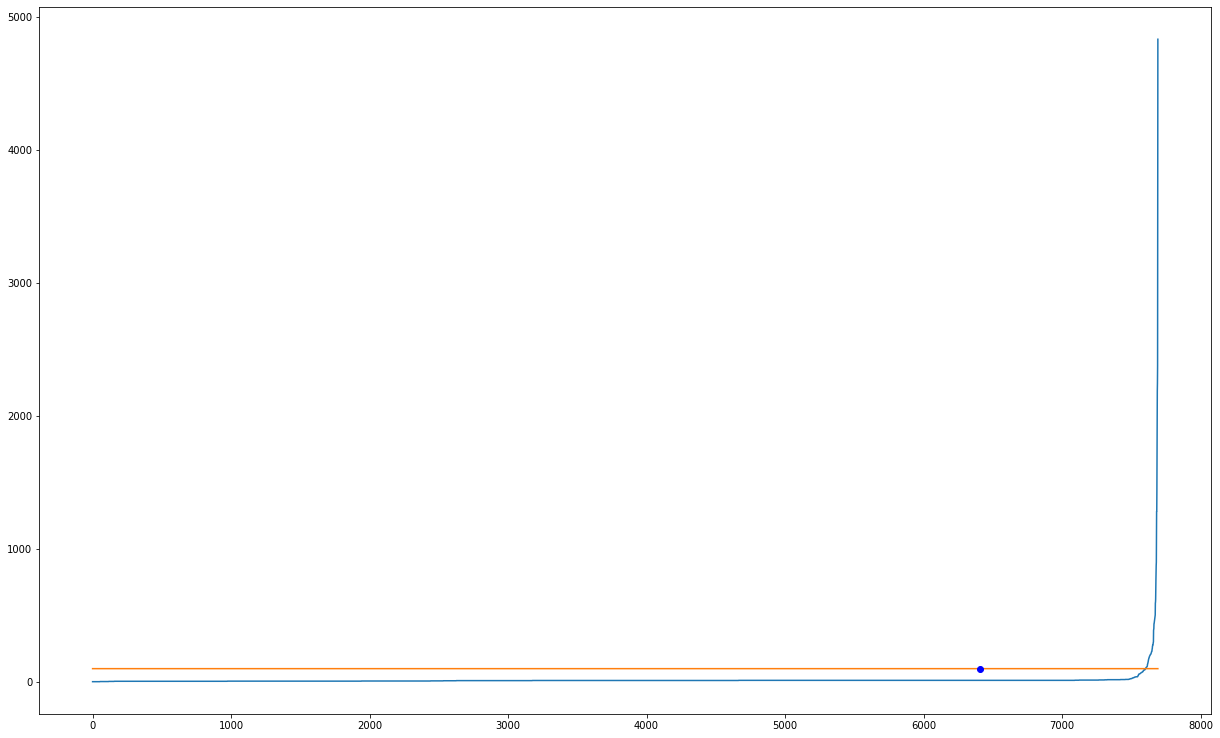

In [34]:
# how the bot determines threshold between entries and exits
amounts = sorted(mtdf.amount.values)
cutoff = 0.83333
threshold = calc_entry_exit_threshold_amount(vwap.my_trades[s], cutoff=cutoff, 
                                             m=vwap.settings['min_exit_cost_multiplier'] - 1)
plt.plot(amounts)
plt.plot(np.repeat(threshold, len(amounts)))
plt.plot([int(cutoff * len(amounts))], [threshold], 'bo')
print(threshold)

In [35]:
big_trades = mtdf[mtdf.amount >= threshold]
small_trades = mtdf[mtdf.amount < threshold]
long_buys = small_trades[small_trades.side == 'buy']
shrt_sels = small_trades[small_trades.side == 'sell']
long_sels = big_trades[big_trades.side == 'sell']
shrt_buys = big_trades[big_trades.side == 'buy']

lbc = long_buys.cost.sum()
lba = long_buys.amount.sum()
lsc = long_sels.cost.sum()
lsa = long_sels.amount.sum()

ssc = shrt_sels.cost.sum()
ssa = shrt_sels.amount.sum()
sbc = shrt_buys.cost.sum()
sba = shrt_buys.amount.sum()

print('total quot vol', mtdf.cost.sum())
print('n_days', round((mtdf.index[-1] - mtdf.index[0]) / 1000 / 60 / 60 / 24, 2))
print()

if lba:
    print('long_buy_cost', round(lbc, 8), 'long_buy_vwap', round(lbc / lba, 10))
if lsa:
    print('long_sel_cost', round(lsc, 8), 'long_sel_vwap', round(lsc / lsa, 10))
if lba and lsa:
    print('long_sel_vwap / long_buy_vwap', round((lsc / lsa) / (lbc / lba), 10))

print()

if ssa:
    print('shrt_sel_cost', round(ssc, 8), 'shrt_sel_vwap', round(ssc / ssa, 10))
if sba:
    print('shrt_buy_cost', round(sbc, 8), 'shrt_buy_vwap', round(sbc / sba, 10))
if ssa and sba:
    print('shrt_sel_vwap / shrt_buy_vwap', round((ssc / ssa) / (sbc / sba), 10))

all_buys = mtdf[mtdf.side == 'buy']
all_sels = mtdf[mtdf.side == 'sell']
abc = all_buys.cost.sum()
aba = all_buys.amount.sum()
asc = all_sels.cost.sum()
asa = all_sels.amount.sum()

print()
print('all buy_cost', round(abc, 8), 'buy_vwap', round(abc / aba, 10))
print('all sel_cost', round(asc, 8), 'sel_vwap', round(asc / asa, 10))
print('all sel_vwap / buy_vwap', round((asc / asa) / (abc / aba), 10))

    


total quot vol 2.73524758
n_days 78.7

long_buy_cost 0.9700066 long_buy_vwap 2.3207e-05
long_sel_cost 0.72180787 long_sel_vwap 2.34232e-05
long_sel_vwap / long_buy_vwap 1.0093136806

shrt_sel_cost 0.67017776 shrt_sel_vwap 2.29993e-05
shrt_buy_cost 0.37325535 shrt_buy_vwap 2.27775e-05
shrt_sel_vwap / shrt_buy_vwap 1.0097381858

all buy_cost 1.34326195 buy_vwap 2.30861e-05
all sel_cost 1.39198563 sel_vwap 2.32172e-05
all sel_vwap / buy_vwap 1.0056796689


long_exit_price / current_price 0.7964


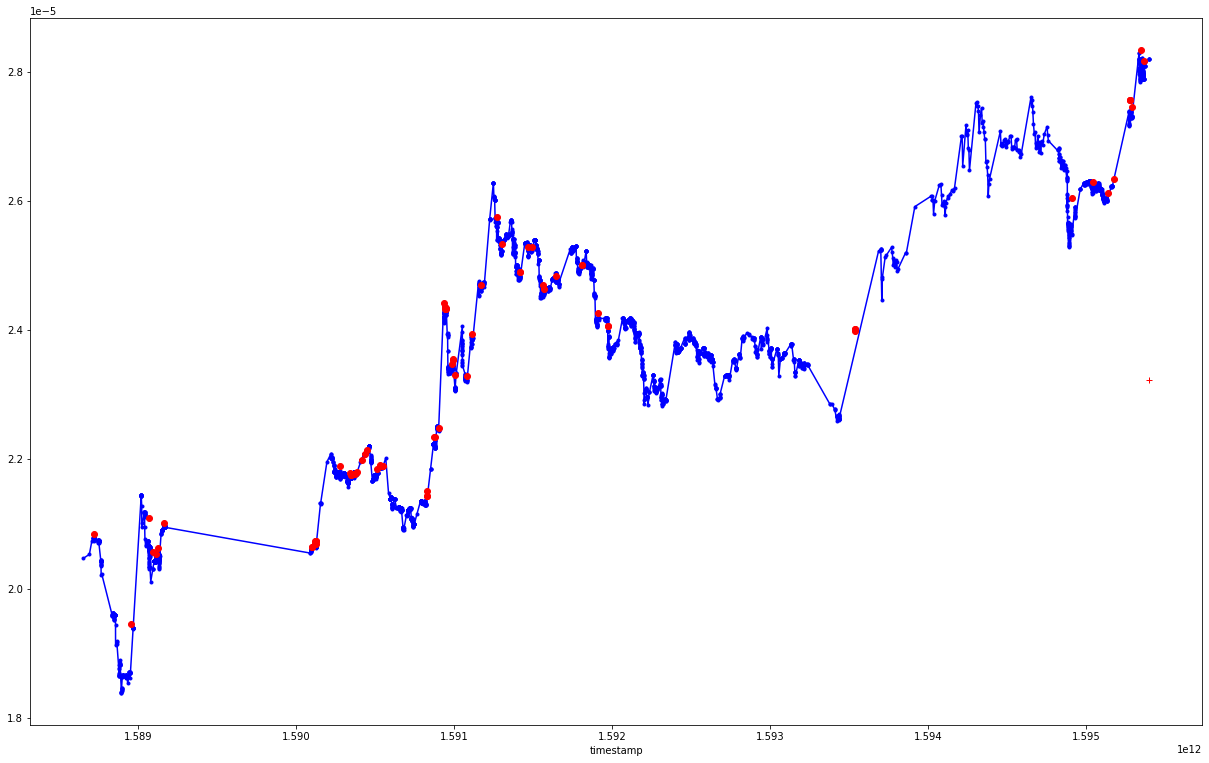

In [36]:
# blue dots are long buys, red dots are long sells, red cross is current long sell price
long_buys.price.plot(style='b.-')
long_sels.price.plot(style='ro')
long_sel_price = vwap.my_trades_analyses[s]['long_sel_price']
if long_sel_price > 0.0:
    plt.plot([long_buys.index[-1]], [long_sel_price], 'r+')
    print(f'long_exit_price / current_price {long_sel_price / vwap.cm.last_price[s]:.4f}')


current_price / shrt_exit_price 1.1867


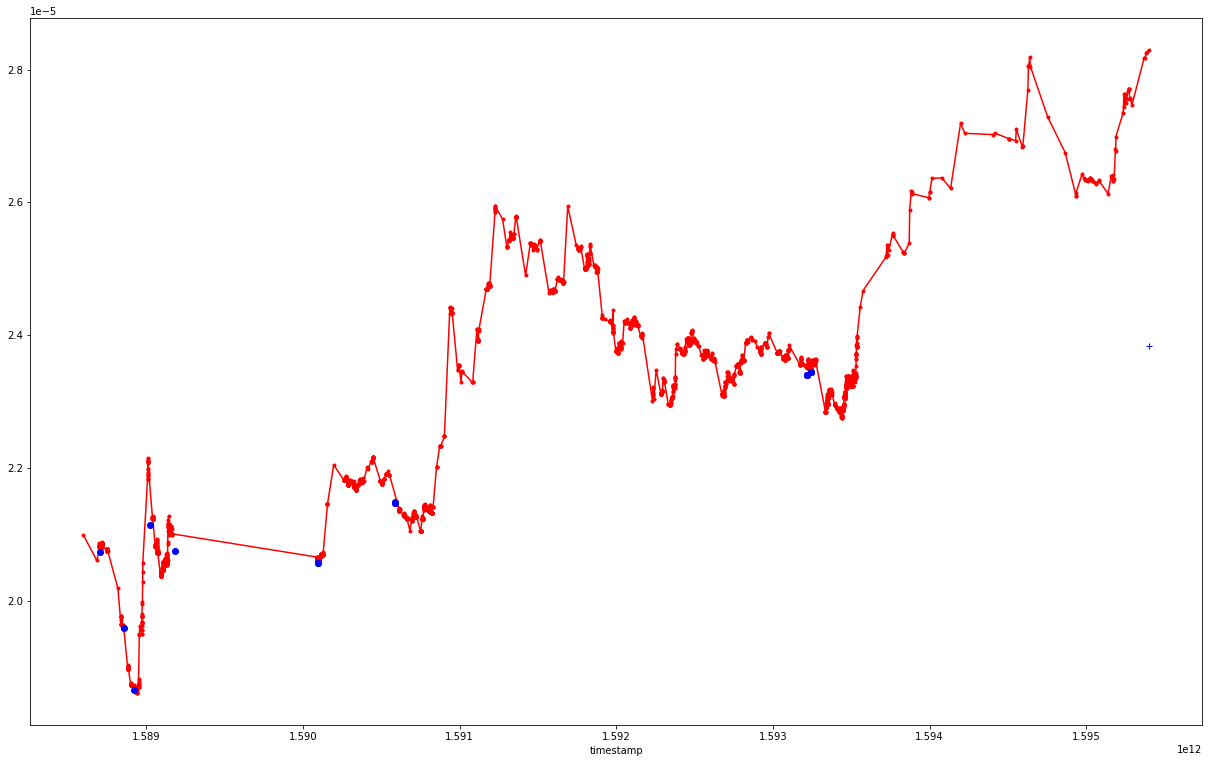

In [37]:
# red dots are short sells, blue dots are short buys, blue cross is current short buy price
shrt_sels.price.plot(style='r.-')
shrt_buys.price.plot(style='bo')
shrt_buy_price = vwap.my_trades_analyses[s]['true_shrt_vwap'] * vwap.settings['profit_pct_minus']
if shrt_buy_price > 0.0:
    plt.plot([shrt_sels.index[-1]], [shrt_buy_price], 'b+')
    print(f'current_price / shrt_exit_price {shrt_sels.iloc[-1].price / shrt_buy_price:.4f}')

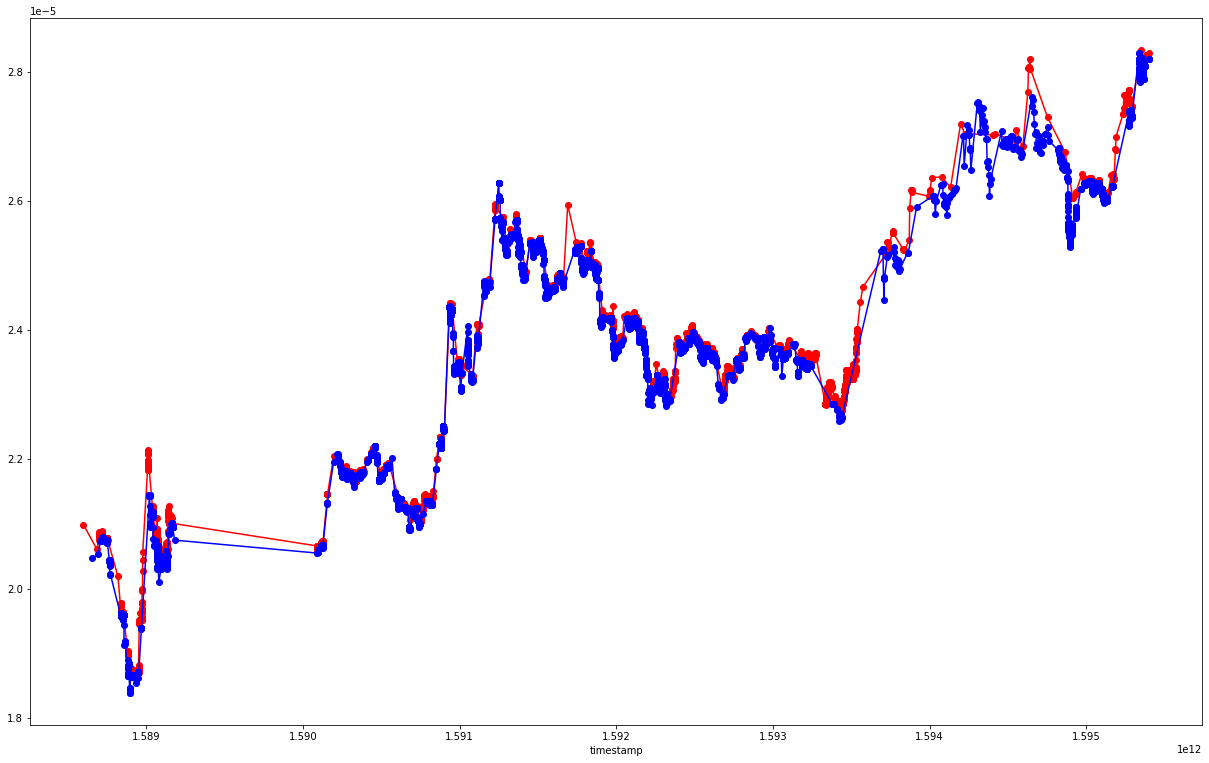

In [38]:
# all buys and sells in one
all_sels.price.plot(style='ro-')
all_buys.price.plot(style='bo-')

In [39]:
tlc = {} # true long costs
tsc = {} # true shrt costs
long_vwaps = {}
shrt_vwaps = {}
for s_ in vwap.my_trades_analyses:
    tlc[s_] = vwap.my_trades_analyses[s_]['true_long_cost']
    tsc[s_] = vwap.my_trades_analyses[s_]['true_shrt_cost']
    long_vwaps[s_] = vwap.my_trades_analyses[s_]['true_long_vwap']
    shrt_vwaps[s_] = vwap.my_trades_analyses[s_]['true_shrt_vwap']
print('exit costs sorted low to high')
for itm in sorted([(e[0], round(e[1], 4)) for e in tlc.items()], key=lambda x: x[1])[-20:]:
    print('true long cost', itm)
print()
for itm in sorted([(e[0], round(e[1], 4)) for e in tsc.items()], key=lambda x: x[1])[-20:]:
    print('true shrt cost', itm)


exit costs sorted low to high
true long cost ('VET/BTC', 0.1074)
true long cost ('XMR/BTC', 0.1084)
true long cost ('QTUM/BTC', 0.1271)
true long cost ('XRP/BTC', 0.1273)
true long cost ('ONT/BTC', 0.1397)
true long cost ('DASH/BTC', 0.1435)
true long cost ('LTC/BTC', 0.1513)
true long cost ('XTZ/BTC', 0.1575)
true long cost ('XLM/BTC', 0.1656)
true long cost ('ETH/BTC', 0.1683)
true long cost ('EOS/BTC', 0.1779)
true long cost ('ETC/BTC', 0.1813)
true long cost ('IOTA/BTC', 0.2023)
true long cost ('BCH/BTC', 0.2069)
true long cost ('BAT/BTC', 0.2516)
true long cost ('ATOM/BTC', 0.267)
true long cost ('ZEC/BTC', 0.3104)
true long cost ('ADA/BTC', 0.3479)
true long cost ('BNB/BTC', 0.3833)
true long cost ('LINK/BTC', 0.996)

true shrt cost ('MATIC/BTC', 0.0787)
true shrt cost ('VET/BTC', 0.1018)
true shrt cost ('XMR/BTC', 0.1196)
true shrt cost ('QTUM/BTC', 0.1403)
true shrt cost ('XTZ/BTC', 0.1433)
true shrt cost ('DASH/BTC', 0.1584)
true shrt cost ('XLM/BTC', 0.1684)
true shrt cost ('

In [40]:
lst = [(e[0], round(e[1], 8), vwap.cm.last_price[e[0]], vwap.cm.last_price[e[0]] / (e[1] if e[1] else 10e-10)) for e in shrt_vwaps.items()]
print('shrts closest to filling:')
for e in sorted(lst, key=lambda x: x[3]):
    if e[0] not in vwap.do_shrt_buy:
        continue
    
    line = f"{e[0]:<12} true shrt cost: {vwap.my_trades_analyses[e[0]]['true_shrt_cost']:.6f}"
    line += f" true shrt vwap: {e[1]:.8f} last price: {e[2]:.8f}"
    line += f" div {e[3]:.4f}"
    print(line)

    
    

shrts closest to filling:
ETC/BTC      true shrt cost: 0.185957 true shrt vwap: 0.00070532 last price: 0.00065800 div 0.9329
DASH/BTC     true shrt cost: 0.158447 true shrt vwap: 0.00813677 last price: 0.00768600 div 0.9446
BCH/BTC      true shrt cost: 0.209914 true shrt vwap: 0.02600837 last price: 0.02466700 div 0.9484
EOS/BTC      true shrt cost: 0.197615 true shrt vwap: 0.00028138 last price: 0.00027790 div 0.9876
RVN/BTC      true shrt cost: 0.066193 true shrt vwap: 0.00000219 last price: 0.00000218 div 0.9942
MATIC/BTC    true shrt cost: 0.078665 true shrt vwap: 0.00000230 last price: 0.00000229 div 0.9943
XRP/BTC      true shrt cost: 0.172310 true shrt vwap: 0.00002111 last price: 0.00002120 div 1.0043
NEO/BTC      true shrt cost: 0.065983 true shrt vwap: 0.00119168 last price: 0.00121000 div 1.0154
XMR/BTC      true shrt cost: 0.119619 true shrt vwap: 0.00715553 last price: 0.00751500 div 1.0502
ETH/BTC      true shrt cost: 0.365872 true shrt vwap: 0.02468436 last price: 0.0260

In [41]:
lst = [(e[0], round(e[1], 8), vwap.cm.last_price[e[0]], e[1] / vwap.cm.last_price[e[0]]) for e in long_vwaps.items()]
print('longs closest to filling:')
for e in sorted(lst, key=lambda x: x[3]):
    if e[0] not in vwap.do_long_sel:
        continue
    
    line = f"{e[0]:<12} true long cost: {vwap.my_trades_analyses[e[0]]['true_long_cost']:.6f}"
    line += f" true long vwap: {e[1]:.8f} last price: {e[2]:.8f}"
    line += f" div {e[3]:.4f}"
    print(line)

    
    

longs closest to filling:
VET/BTC      true long cost: 0.107437 true long vwap: 0.00000103 last price: 0.00000185 div 0.5581
LINK/BTC     true long cost: 0.996036 true long vwap: 0.00047541 last price: 0.00080804 div 0.5884
ADA/BTC      true long cost: 0.347891 true long vwap: 0.00000873 last price: 0.00001305 div 0.6688
ONT/BTC      true long cost: 0.139729 true long vwap: 0.00005525 last price: 0.00007850 div 0.7038
XLM/BTC      true long cost: 0.165612 true long vwap: 0.00000784 last price: 0.00001034 div 0.7580
QTUM/BTC     true long cost: 0.127105 true long vwap: 0.00019440 last price: 0.00024820 div 0.7832
NEO/BTC      true long cost: 0.050782 true long vwap: 0.00095114 last price: 0.00121000 div 0.7861
IOTA/BTC     true long cost: 0.202264 true long vwap: 0.00002317 last price: 0.00002917 div 0.7943
ATOM/BTC     true long cost: 0.266966 true long vwap: 0.00035133 last price: 0.00042590 div 0.8249
ZEC/BTC      true long cost: 0.310353 true long vwap: 0.00555989 last price: 0.0065

In [42]:
# past 24h vol per symbol
age_limit = vwap.cc.milliseconds() - 1000 * 60 * 60 * 24 * 7
vols = []
for s_ in vwap.my_trades:
    vols.append((round(sum([e['cost'] for e in vwap.my_trades[s_] if e['timestamp'] > age_limit]), 4), s_))
print(sum([e[0] for e in vols]))
sorted(vols)

5.765300000000001


[(0.0118, 'IOST/BTC'),
 (0.0334, 'TRX/BTC'),
 (0.0635, 'RVN/BTC'),
 (0.084, 'VET/BTC'),
 (0.0859, 'MATIC/BTC'),
 (0.0996, 'ETH/BTC'),
 (0.122, 'EOS/BTC'),
 (0.149, 'BCH/BTC'),
 (0.1623, 'DASH/BTC'),
 (0.1676, 'NEO/BTC'),
 (0.1739, 'XRP/BTC'),
 (0.1824, 'IOTA/BTC'),
 (0.1962, 'ZEC/BTC'),
 (0.21, 'ETC/BTC'),
 (0.2218, 'ONT/BTC'),
 (0.2566, 'QTUM/BTC'),
 (0.2983, 'ADA/BTC'),
 (0.3012, 'BAT/BTC'),
 (0.3037, 'LTC/BTC'),
 (0.3266, 'XMR/BTC'),
 (0.3337, 'XLM/BTC'),
 (0.3402, 'ATOM/BTC'),
 (0.3902, 'BNB/BTC'),
 (0.3971, 'XTZ/BTC'),
 (0.8543, 'LINK/BTC')]

In [43]:
# overall performance analysis

In [44]:
r = []
n_days = 30 # set n_days
start_ts = vwap.cc.milliseconds() - 1000 * 60 * 60 * 24 * n_days
for s_ in sorted(vwap.my_trades):
    sys.stdout.write(f'\r{s_}  ')
    sys.stdout.flush()
    mt = vwap.fetch_my_trades(s_)
    mtdf = pd.DataFrame(mt).set_index('timestamp')
    mtdf = mtdf[mtdf.index > start_ts]
    actual_n_days = (mtdf.index[-1] - mtdf.index[0]) / 1000 / 60 / 60 / 24
    buys = mtdf[mtdf.side == 'buy']
    sels = mtdf[mtdf.side == 'sell']
    bcost = buys.cost.sum()
    bamount = buys.amount.sum()
    bvwap = bcost / bamount
    scost = sels.cost.sum()
    samount = sels.amount.sum()
    svwap = scost / samount
    div_ = svwap / bvwap
    r.append({'bcost': bcost, 'scost': scost, 'svwap_bvwap': div_, 'actual_n_days': actual_n_days,
              'symbol': s_, 'cost': scost + bcost})

ZEC/BTC    

In [45]:
rdf = pd.DataFrame(r)
rdf.loc[:,'vwg'] = (rdf.svwap_bvwap - 1) * rdf.cost / rdf.cost.sum()
rdf.sort_values('vwg')

,bcost,scost,svwap_bvwap,actual_n_days,symbol,cost,vwg
1,0.340683518,0.338055722,0.9947925725,29.7262934028,ATOM/BTC,0.678739240,-0.0002165456
18,0.024256730,0.064776330,0.9603271935,29.9391552199,TRX/BTC,0.089033060,-0.0002164050
12,0.497048810,0.354824880,0.9981148203,29.9519741898,LTC/BTC,0.851873690,-0.0000983900
20,0.300662740,0.300289100,0.9988756710,29.7137120255,XLM/BTC,0.600951840,-0.0000413958
19,0.048248570,0.049113790,0.9971123627,28.9920875579,VET/BTC,0.097362360,-0.0000172249
9,0.012470630,0.010922170,1.0252717216,28.7482272222,IOST/BTC,0.023392800,0.0000362193
2,0.268731510,0.268300860,1.0016509476,29.7109867824,BAT/BTC,0.537032370,0.0000543196
3,0.383909084,0.385863963,1.0030871555,29.9963183218,BCH/BTC,0.769773047,0.0001455943
0,0.218205910,0.219581280,1.0058684185,29.9688535069,ADA/BTC,0.437787190,0.0001574009
7,0.350140830,0.352008389,1.0039938128,29.9060020255,ETC/BTC,0.702149219,0.0001718068


In [46]:
(rdf.svwap_bvwap * rdf.cost / rdf.cost.sum()).sum()

1.0083416858801855

In [47]:
# view balance logs

In [48]:
with open(f'logs/binance/{user}/balance_margin.txt') as f:
    lines = f.readlines()

In [49]:
bals = sorted([json.loads(line) for line in lines], key=lambda x: x['timestamp'])[2:]
ndays = (bals[-1]['timestamp'] - bals[0]['timestamp']) / 1000 / 60 / 60 / 24
print('n_days', ndays)

n_days 51.22917362268518


In [50]:
len(bals)

1245

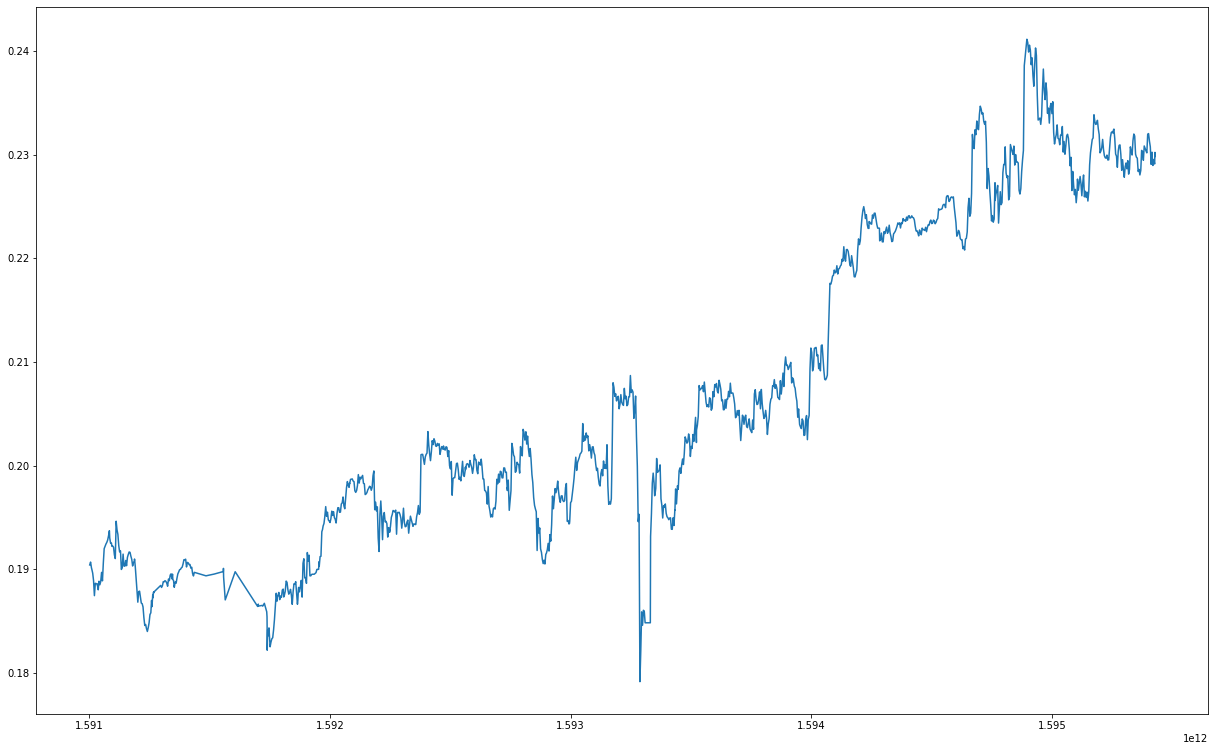

In [51]:
plt.plot([b['timestamp'] for b in bals], [b['BTC']['account_equity'] for b in bals])

In [52]:
print('average daily gain')
(bals[-1]['BTC']['account_equity'] / bals[0]['BTC']['account_equity'])**(1 / ndays)

average daily gain


1.003681216942241

In [53]:
'''
p * adg**ndays = r
adg**ndays = r / p
adg = (r / p)**(1 / ndays)
'''

'\np * adg**ndays = r\nadg**ndays = r / p\nadg = (r / p)**(1 / ndays)\n'